In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Spotipy library which is a Python client for the Spotify Web API.
import spotipy
#SpotifyClientCredentials class from Spotipy for authentication.
from spotipy.oauth2 import SpotifyClientCredentials
# ReadTimeout exception from the requests library to handle timeout errors.
from requests.exceptions import ReadTimeout
# SpotifyException from Spotipy to handle Spotify-specific errors.
from spotipy.exceptions import SpotifyException
# time module to use functions like sleep for pausing execution.
import time

#!pip install langdetect nltk
from langdetect import detect, DetectorFactory

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE

import nltk
import spacy
import re
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Scraping:

##### The Below code interacts with the Spotify Web API using the Spotipy library to collect data on tracks from different genres and markets. Here's a breakdown of each step:

In [37]:
#Storing the Credentials
client_id = '696604424d2c48bd942131d6cfe4786b'
client_secret = '63c6aab43d0843d79d7403584ae42b34'


# Initializing Spotify client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Retrieving available genres for recommendations
genres = (sp.recommendation_genre_seeds())['genres']

#  creating a list of markets as we want only english tracks
markets = ['US', 'GB','IN','AU','CA']

# Defining a function to loop through the markets and genres
def get_tracks_for_genre_and_market(genre, market):
    track_data = []
    # Search() :searches for tracks in a given genre and market, limited to 50 results at a time.
    results = sp.search(q=f'genre:{genre}', limit=50, type='track', market=market) 
    
    while results and len(track_data) < 30000:
        track_ids = [item['id'] for item in results['tracks']['items']]  
        if not track_ids:
            break
        
        # Fetching the required audio features
        audio_features = sp.audio_features(track_ids) 
        
        for i, item in enumerate(results['tracks']['items']): # returns an iterator that produces pairs of an index and the corresponding item from the iterable.
            track = item
            features = audio_features[i] if audio_features[i] else {}
            track_info = {
                'Name': track['name'],
                'Artist': track['artists'][0]['name'],
                'Genre': genre, # The genre of the track.
                'Popularity': track['popularity'], # Popularity of the track.
                'Acousticness': features.get('acousticness', None), # Likelihood of the track being acoustic.
                'Danceability': features.get('danceability', None), # Suitability for dancing.
                'Energy': features.get('energy', None), # Intensity and activity of the track.
                'Instrumentalness': features.get('instrumentalness', None), # Likelihood of the track being instrumental.
                'Liveness': features.get('liveness', None), # Presence of audience in the recording.
                'Loudness': features.get('loudness', None), # Overall loudness of the track.
                'Speechiness': features.get('speechiness', None), # Presence of spoken words.
                'Tempo': features.get('tempo', None), # Tempo of the track in beats per minute (BPM).
                'Valence': features.get('valence', None), # Musical positiveness conveyed.
                'Mode':features.get('mode', None), # Represents the musical mode (Major or Minor). It will be 1 for Major and 0 for Minor.
                'Key':features.get('key', None) ,  # Represents the musical key. It is an integer from 0 to 11 corresponding to musical notes (C = 0, C♯/D♭ = 1, etc.).
                'Duration_ms': track['duration_ms'], # Duration of the track in milliseconds.
                'release_date': track['album']['release_date']
            }
            track_data.append(track_info)
        
            if len(track_data) >= 30000:
                break
        
        results = sp.next(results) if results.get('next') else None # Fetches the next set of results if available, otherwise, stops. 
    
    return track_data
    
#Creating an empty list to store the tracks
all_tracks = []
try:
    for genre in genres:
        for market in markets:
            track_data = get_tracks_for_genre_and_market(genre, market)
            all_tracks.extend(track_data)
            print(f"Tracks collected: {len(all_tracks)} from market {market}") # Printing the tracks collection 
            
            if len(all_tracks) >= 30000:
                all_tracks = all_tracks[:30000]
                break
except (ReadTimeout, SpotifyException) as e:
    print(f"Error occurred: {e}")
    time.sleep(5)       # Pause before retrying to avoid rate limit issues

print(f"Total tracks collected: {len(all_tracks)}")

Tracks collected: 50 from market US
Tracks collected: 100 from market GB
Tracks collected: 150 from market AU
Tracks collected: 200 from market CA
Tracks collected: 250 from market NZ
Tracks collected: 300 from market US
Tracks collected: 350 from market GB
Tracks collected: 400 from market AU
Tracks collected: 450 from market CA
Tracks collected: 500 from market NZ
Tracks collected: 550 from market US
Tracks collected: 600 from market GB
Tracks collected: 650 from market AU
Tracks collected: 700 from market CA
Tracks collected: 750 from market NZ
Tracks collected: 800 from market US
Tracks collected: 850 from market GB
Tracks collected: 900 from market AU
Tracks collected: 950 from market CA
Tracks collected: 1000 from market NZ
Tracks collected: 1050 from market US
Tracks collected: 1100 from market GB
Tracks collected: 1150 from market AU
Tracks collected: 1200 from market CA
Tracks collected: 1250 from market NZ
Tracks collected: 1300 from market US
Tracks collected: 1350 from mark

Max Retries reached


Error occurred: http status: 429, code:-1 - /v1/audio-features/?ids=36gcliMRX1vCpgnrZE3dFZ,6BePGk3eCan4FqaW2X8Qy3,4EmH2iRucAgCOnhuJRotUi,5YaskwnGDZFDRipaqzbwQx,18asYwWugKjjsihZ0YvRxO,6f3Slt0GbA2bPZlz0aIFXN,3IhM5Mber8KA0NaRNpK2px,2nwmp06W0pxsQltnsW4ElE,57uNXnf4ciHYP4HktbIbzC,4wtR6HB3XekEengMX17cpc,5E1XI3JnHOoSEcY2hYnbhj,0zKbDrEXKpnExhGQRe9dxt,4kWO6O1BUXcZmaxitpVUwp,2x4JC9TxW2LACuuxbsncfG,6wLqNGHQIja6xqT0cfrzBB,3j11iDncb7ZeDMw7lFucqM,5f69wzvle0b9ColR7wuvEK,0BLxPjFEOG8G1q8AKLuz3V,5pNFibJLq7dvoDVIIcQBkn,5GjnIpUlLGEIYk052ISOw9,10EpXLXKHmNSVKvX7A5hg8,7mobUfp1aL8A6CdugCMWft,6FAmtZoa7jq6bH9GBjCRkM,7fZtgiJSNJ2QarKKKSssBp,3jksOdXCaDXyGiZ7L4YZbp,6ibDVMcMUNqZ5eXT9sD4Vy,2f2dRxjiUOoV5qhZFbnVO6,1moFkZDqcjQNeXtyoanLHv,2yEHX6MqAXPyD7bm47A2Br,77OuOZhDxJSQLYnNIpX2AG,0IAFmrpi9KF0PP3LONJonm,4vvnuJlgBeNVwq3TNmLMNX,4PNKy9P3xrzqMwVzRjxBKt,4bczCp8ojdY0R4EpCaqkfQ,2YOuBWIyHgyvHnLMpjzBf2,3qCCQas6tIP15Yjgu3gl9S,1uWUn8OYhfcc8xf94W3BqZ,1g5Jqwo02PuitYfv19B6Jn,05c4AAJKIulqI8vQQ41Rch,19bua05ITWjFrk9iGxOA7r,0W4N0KzHKWQp

In [57]:
# Converting the data to a Dataframe
df=pd.DataFrame(all_tracks)
# saving the complete dataset
df.to_excel('tracks.xlsx',index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27450 entries, 0 to 27449
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              27450 non-null  object 
 1   Artist            27450 non-null  object 
 2   Genre             27450 non-null  object 
 3   Popularity        27450 non-null  int64  
 4   Acousticness      27450 non-null  float64
 5   Danceability      27450 non-null  float64
 6   Energy            27450 non-null  float64
 7   Instrumentalness  27450 non-null  float64
 8   Liveness          27450 non-null  float64
 9   Loudness          27450 non-null  float64
 10  Speechiness       27450 non-null  float64
 11  Tempo             27450 non-null  float64
 12  Valence           27450 non-null  float64
 13  Mode              27450 non-null  int64  
 14  Key               27450 non-null  int64  
 15  Duration_ms       27450 non-null  int64  
 16  release_date      27450 non-null  object

In [59]:
# Extracting only english songs from the dataset

# Ensure consistent results
DetectorFactory.seed = 0


def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Apply the language detection function
df['is_english'] = df['Name'].apply(is_english)  

# Filter out only English tracks
english_tracks = df[df['is_english']]


english_tracks.reset_index(inplace=True)
english_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13794 entries, 0 to 13793
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             13794 non-null  int64  
 1   Name              13794 non-null  object 
 2   Artist            13794 non-null  object 
 3   Genre             13794 non-null  object 
 4   Popularity        13794 non-null  int64  
 5   Acousticness      13794 non-null  float64
 6   Danceability      13794 non-null  float64
 7   Energy            13794 non-null  float64
 8   Instrumentalness  13794 non-null  float64
 9   Liveness          13794 non-null  float64
 10  Loudness          13794 non-null  float64
 11  Speechiness       13794 non-null  float64
 12  Tempo             13794 non-null  float64
 13  Valence           13794 non-null  float64
 14  Mode              13794 non-null  int64  
 15  Key               13794 non-null  int64  
 16  Duration_ms       13794 non-null  int64 

In [61]:
# Save the filtered dataset
english_tracks.to_excel('Hollywood_tracks.xlsx', index=False)

# Exploratory Data Analysis:

In [4]:
df=pd.read_excel(r"C:\Users\sahub\Desktop\P426_Project\Hollywood_tracks.xlsx")

In [331]:
df.head()

,index,Name,Artist,Genre,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms,release_date,is_english
0,0,Blister In The Sun,Violent Femmes,acoustic,71,0.3160,0.726,0.537,0.00000,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706,1983-01-01,True
1,1,Love Song,Sara Bareilles,acoustic,73,0.0208,0.583,0.786,0.00000,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826,2007-07-03,True
2,3,Hold On,Chord Overstreet,acoustic,77,0.4690,0.618,0.443,0.00000,0.0829,-9.681,0.0526,119.949,0.167,1,2,198853,2017-02-03,True
3,5,You Are the Best Thing,Ray LaMontagne,acoustic,67,0.0304,0.578,0.727,0.00002,0.1720,-4.872,0.0332,170.593,0.885,1,10,231840,2008-10-13,True
4,6,I Won't Give Up,Jason Mraz,acoustic,67,0.6940,0.483,0.303,0.00000,0.1150,-10.058,0.0429,133.406,0.139,1,4,240165,2012-04-13,True


In [5]:
# Just dropping unnecessary columns
df=df.drop(['index','is_english'],axis=1)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13794 entries, 0 to 13793
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              13794 non-null  object 
 1   Artist            13794 non-null  object 
 2   Genre             13794 non-null  object 
 3   Popularity        13794 non-null  int64  
 4   Acousticness      13794 non-null  float64
 5   Danceability      13794 non-null  float64
 6   Energy            13794 non-null  float64
 7   Instrumentalness  13794 non-null  float64
 8   Liveness          13794 non-null  float64
 9   Loudness          13794 non-null  float64
 10  Speechiness       13794 non-null  float64
 11  Tempo             13794 non-null  float64
 12  Valence           13794 non-null  float64
 13  Mode              13794 non-null  int64  
 14  Key               13794 non-null  int64  
 15  Duration_ms       13794 non-null  int64  
 16  release_date      13794 non-null  object

In [67]:
print('Count of null values:',df.isnull().sum().sum())

Count of null values: 0


In [6]:
print('Count of duplicated values:')
df.duplicated().sum()

Count of duplicated values:


8754

#### Categorical columns:

In [7]:
print('Artist, genre, Mode and Key are the categorical columns.\n')
genres=df['Genre'].unique()
print("List of genres:\n",genres)
print("\nCount of genres:",df['Genre'].nunique())
print("\nList of unique values in mode are",df['Mode'].unique())
print('\nList of unique values in key are',df['Key'].unique())
print('\nNo of unique values in Artist are',df['Artist'].nunique())

Artist, genre, Mode and Key are the categorical columns.

List of genres:
 ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro' 'electronic'
 'emo' 'folk' 'french' 'funk' 'garage' 'german' 'gospel' 'goth'
 'grindcore' 'groove' 'grunge' 'guitar' 'happy' 'hard-rock' 'hardcore'
 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk' 'house' 'idm' 'indian'
 'indie' 'indie-pop' 'industrial' 'iranian' 'j-dance' 'j-idol' 'j-pop'
 'j-rock' 'jazz' 'k-pop' 'kids' 'latin' 'latino' 'malay' 'mandopop'
 'metal' 'metalcore' 'minimal-techno' 'mpb' 'new-age' 'opera' 'pagode'
 'party' 'piano' 'pop' 'pop-film' 'power-pop' 'progressive-house'
 'psych-rock' 'punk' 'punk-rock' 'r-n-b' 'reggae' 'reggaeton' 'rock'
 'rock-n-roll' 'rock

#### Numerical Columns:

In [8]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical variables:', len(numerical_features))
df[numerical_features].head(2)

Number of numerical variables: 13


,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms
0,71,0.3160,0.726,0.537,0.0,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706
1,73,0.0208,0.583,0.786,0.0,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826


In [9]:
df.describe()

,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms
count,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,13794.000000,1.379400e+04
mean,64.303175,0.262671,0.579024,0.648000,0.137969,0.183070,-8.224556,0.077675,122.826659,0.498532,0.635059,5.347832,2.167082e+05
std,16.442691,0.319897,0.174070,0.252896,0.292506,0.152333,5.433831,0.080799,28.899176,0.258976,0.481431,3.556048,7.556606e+04
min,2.000000,0.000001,0.000000,0.000020,0.000000,0.015700,-43.938000,0.000000,0.000000,0.000000,0.000000,0.000000,3.096500e+04
25%,55.000000,0.009200,0.467000,0.473750,0.000000,0.093000,-10.050000,0.035000,101.814000,0.288000,0.000000,2.000000,1.708900e+05
50%,66.000000,0.099250,0.592000,0.697000,0.000099,0.121000,-6.655000,0.048100,123.046000,0.496500,1.000000,6.000000,2.094890e+05
75%,77.000000,0.466000,0.705000,0.862000,0.037900,0.222000,-4.804000,0.081175,139.933000,0.709000,1.000000,8.000000,2.448795e+05
max,97.000000,0.996000,0.980000,1.000000,0.999000,0.984000,1.221000,0.947000,235.907000,0.985000,1.000000,11.000000,1.400000e+06


In [10]:
# Convert the date column to datetime
df['release_date'] = pd.to_datetime(df['release_date'],format='ISO8601')

# Extract the year 
df['Release_Year'] = df['release_date'].dt.year


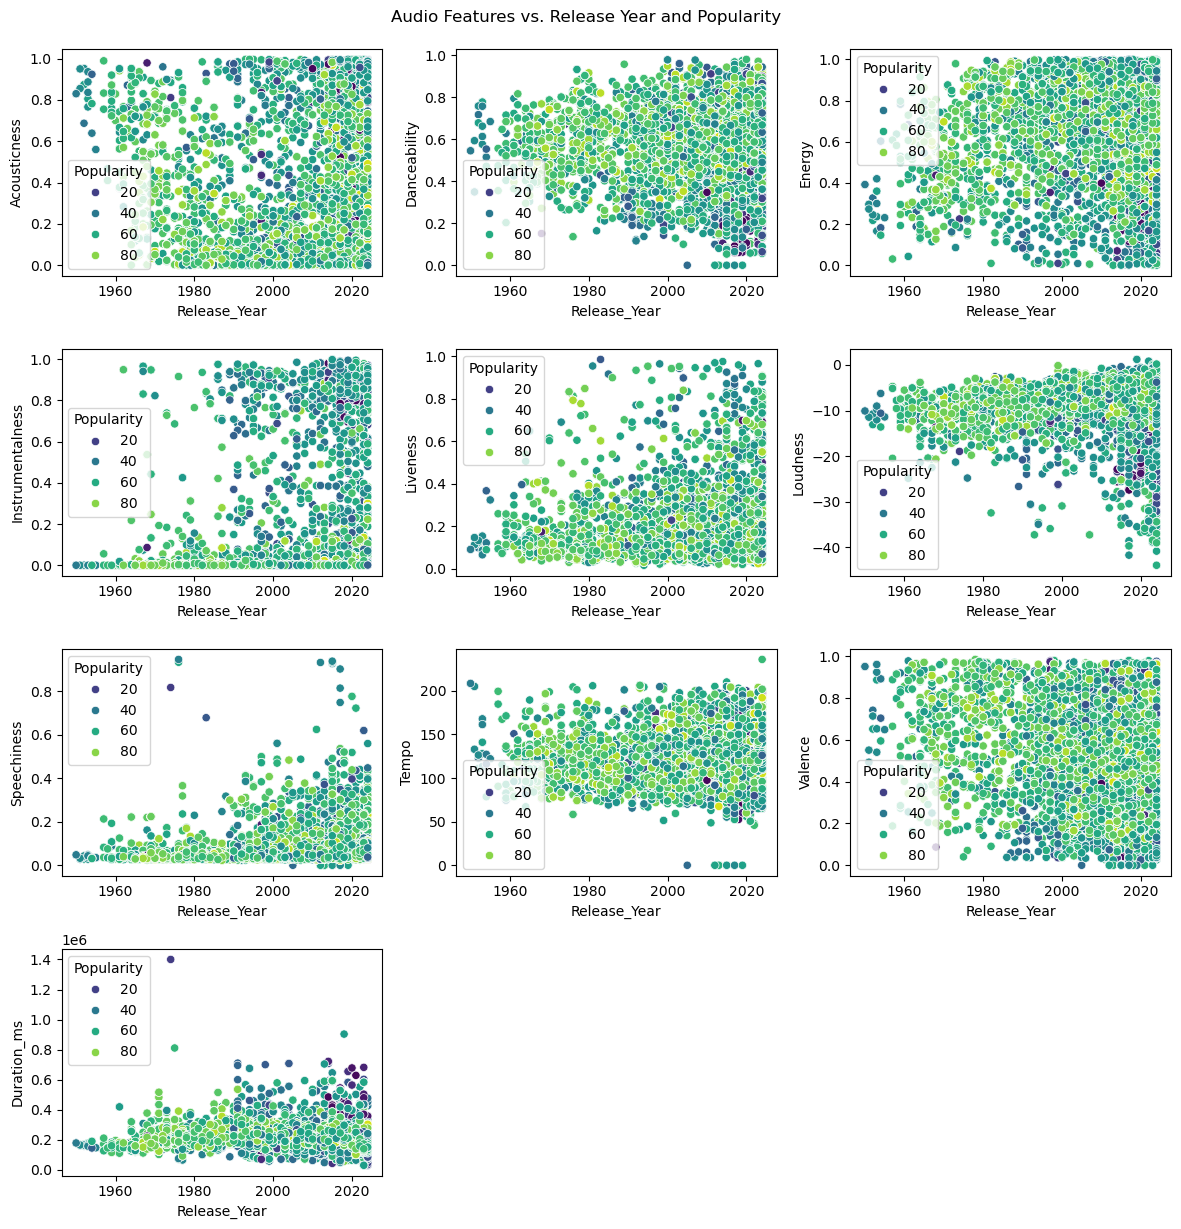

In [14]:
# Define the audio features and popularity
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Duration_ms']

plt.figure(figsize=(12,12))
# Plot each feature against Popularity and Release Year
for i, feature in enumerate(features,start=1):
    plt.subplot(4,3,i)
    sns.scatterplot(x='Release_Year', y=feature, hue='Popularity', data=df, palette='viridis')
    
plt.tight_layout()
plt.suptitle('Audio Features vs. Release Year and Popularity', y=1.02)
plt.show()


+ The graph illustrates the changes in audio feature popularity over the years.
+ For instance, acousticness scores between 0 and 0.6 have consistently been popular.
+ Danceability scores in the range of 0.4 to 0.8 have remained popular over time.
+ The popularity of energy scores above 0.4 has been increasing over the years.
+ Loudness levels between 0 and -10 dB are notably popular, as indicated by their consistently low values.
+ Songs with moderate speechiness have seen a rise in popularity over the years.

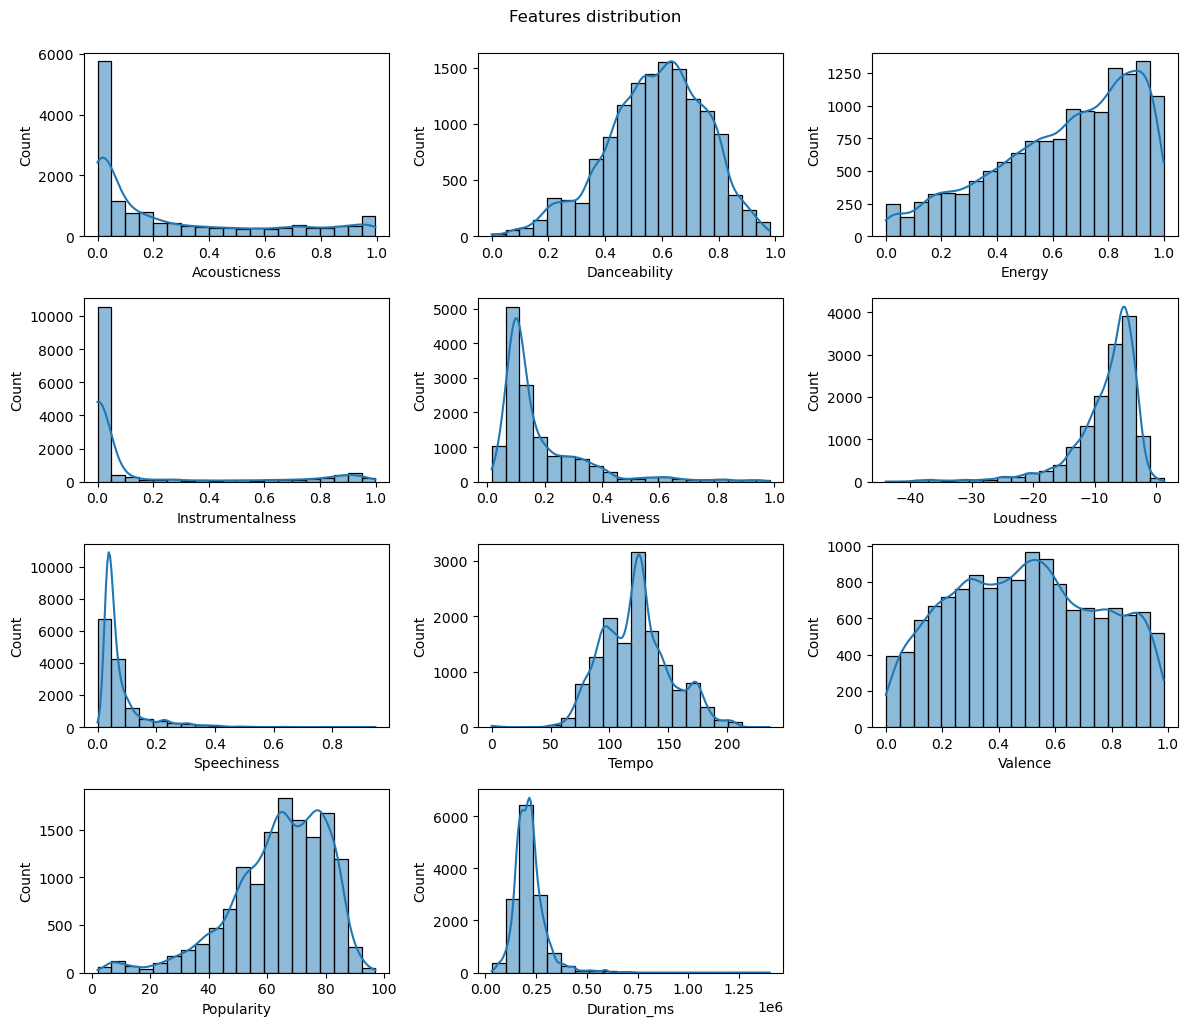

In [238]:
# Feature distributions
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Popularity','Duration_ms']

plt.figure(figsize=(12,12))
# Plot each feature against Popularity and Release Year
for i, feature in enumerate(features,start=1):
    plt.subplot(5,3,i)
    sns.histplot(df[feature], bins=20,kde=True)
    
plt.tight_layout()
plt.suptitle('Features distribution', y=1.02)
plt.show()

The above graphs show the feature distribution.  
As we can see some of the features are right skewed like acousticness, instrumentalness, liveness,speechiness and some of them are slightly left skewed like danceability, energy, popularity.  
Some of the features are slight normal distributions like tempo, duration_ms, valence.

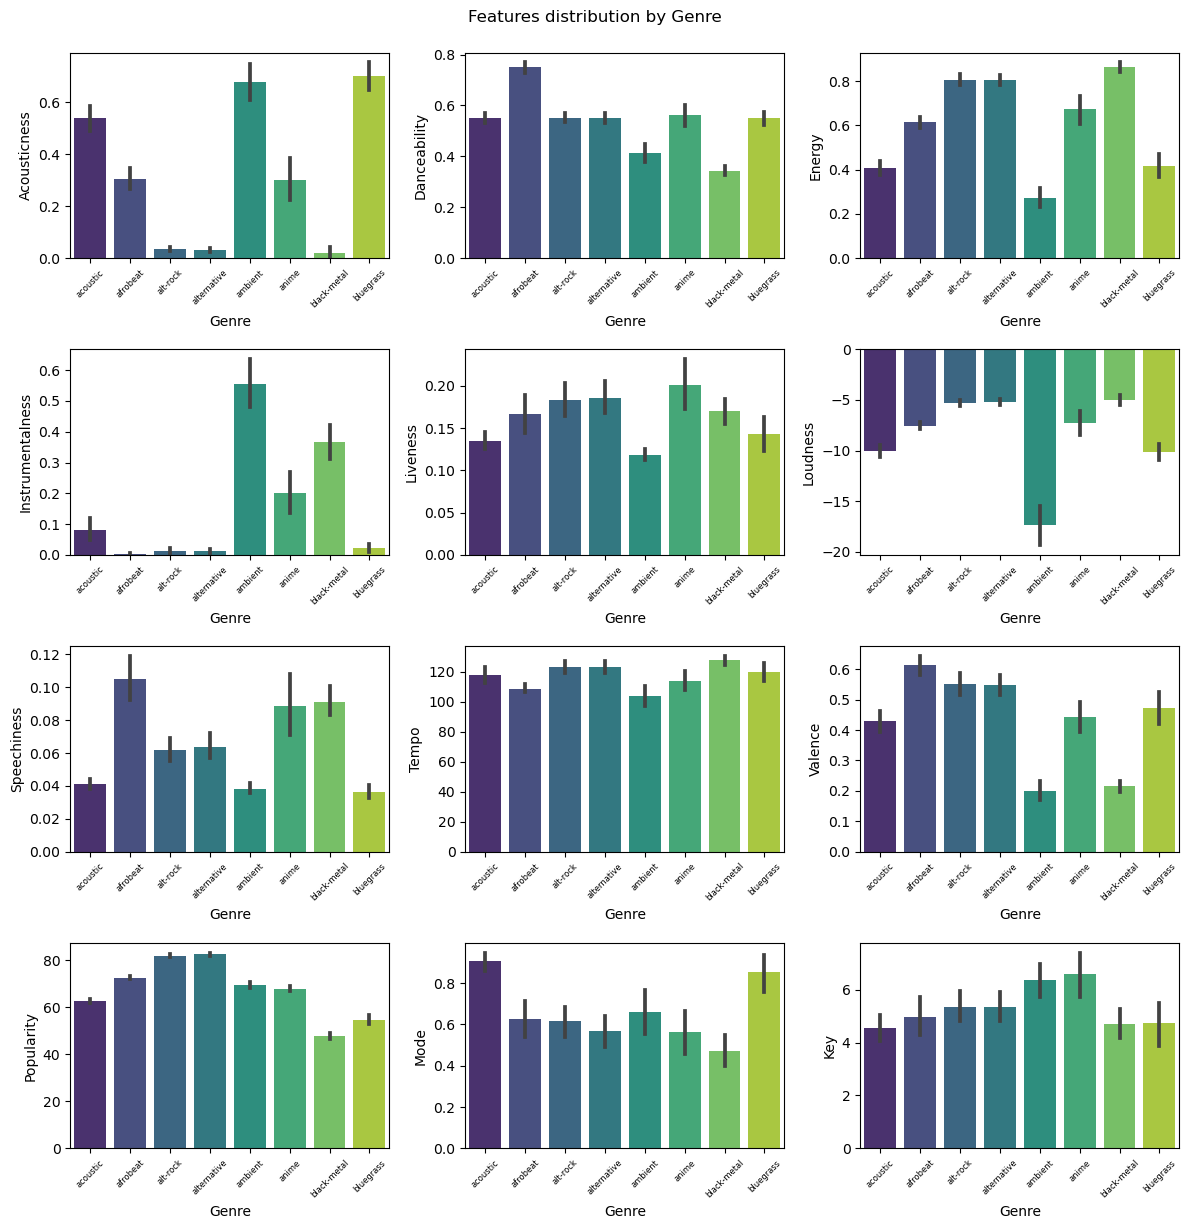

In [73]:
# Genre vs all the features
features = ['Acousticness', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence','Popularity','Mode','Key']
plt.figure(figsize=(12,12))

for i, feature in enumerate(features,start=1):
    plt.subplot(4,3,i)
    sns.barplot(data=df.iloc[:1000,:], x='Genre', y=feature, palette='viridis')
    plt.xticks(rotation=45,fontsize=6)
plt.tight_layout()
plt.suptitle('Features distribution by Genre',y=1.02)
plt.show()

The above graph shows how the features distributed by genres.  
We have just taken first 10 genres.   
We can conclude:    
The tempo is kind of similar for all the 10 genres.  
Instrumentalness changing drastically for different genres etc.  

In [4]:
corr=df[['Popularity', 'Acousticness', 'Danceability',
       'Duration_ms', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence']].corr()

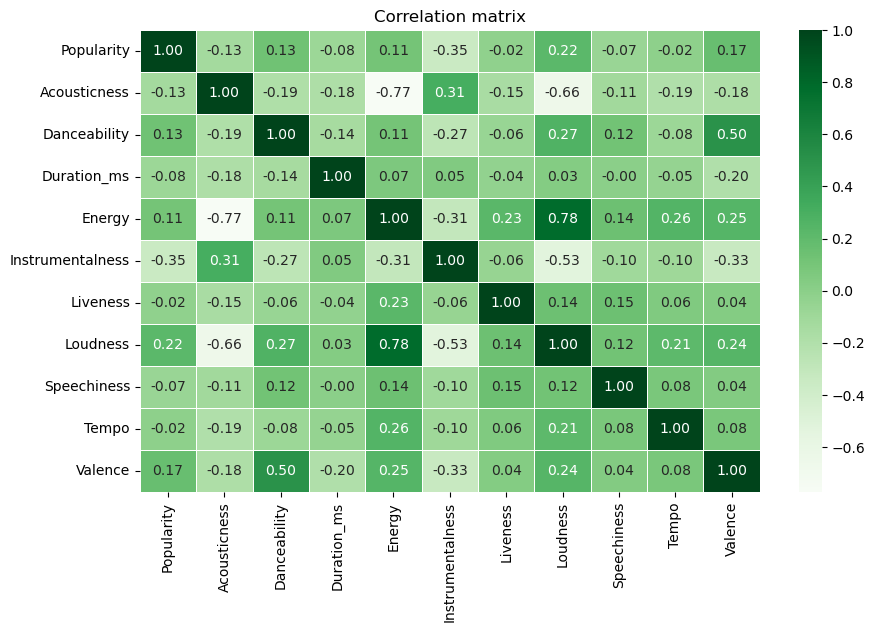

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True, fmt='.2f',cmap='Greens',linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

In [31]:
print("Features having collinearity greater than 0.6")
for i, row in corr.iterrows():
    for col in corr.columns:
        corr_value=row[col]
        if abs(corr_value) > 0.5 and (i!= col and i < col):
            print(f"{i}, {col}: {corr_value}")
        else:
            continue

Features having collinearity greater than 0.6
Acousticness, Energy: -0.7734411569480996
Acousticness, Loudness: -0.6568653006988825
Danceability, Valence: 0.5023430387823572
Energy, Loudness: 0.784360806624906
Instrumentalness, Loudness: -0.5269294347100901


From above we can see that,   
Loudness and acousticness are having multicollinearity so we will be dropping loudness and acousticness.

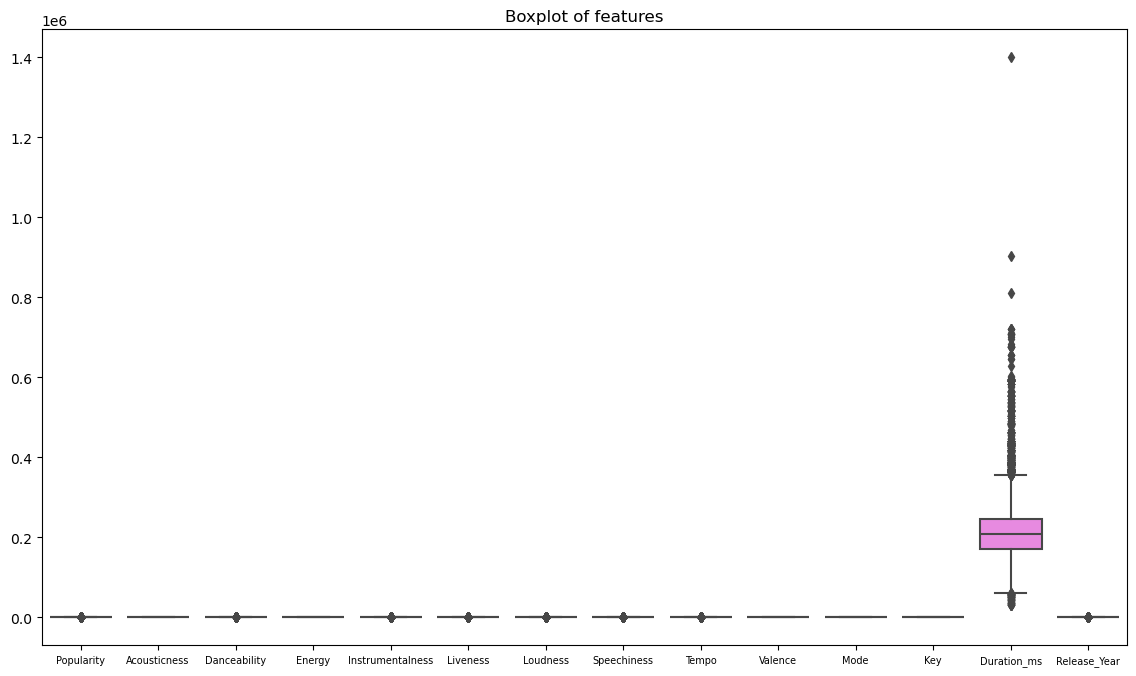

In [77]:
plt.figure(figsize=(14,8))
sns.boxplot(df)
plt.xticks(fontsize=7)
plt.title('Boxplot of features')
plt.show()

As we can see from above, the duration_ms is the only feature having outliers.It could be because of scaling as the values are on large scale. Hence we are ignoring it for now.

In [78]:
df.columns

Index(['Name', 'Artist', 'Genre', 'Popularity', 'Acousticness', 'Danceability',
       'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness',
       'Tempo', 'Valence', 'Mode', 'Key', 'Duration_ms', 'release_date',
       'Release_Year'],
      dtype='object')

# Data Preprocessing:

In [196]:
df[df[['Name','Artist','Genre']].duplicated()]

,Name,Artist,Genre,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Mode,Key,Duration_ms,release_date
37,Hold On,Chord Overstreet,acoustic,77,0.46900,0.618,0.443,0.000000,0.0829,-9.681,0.0526,119.949,0.167,1,2,198853,2017-02-03
38,Love Song,Sara Bareilles,acoustic,73,0.02080,0.583,0.786,0.000000,0.1880,-3.142,0.0301,123.055,0.573,0,2,258826,2007-07-03
39,I Won't Give Up,Jason Mraz,acoustic,67,0.69400,0.483,0.303,0.000000,0.1150,-10.058,0.0429,133.406,0.139,1,4,240165,2012-04-13
40,Blister In The Sun,Violent Femmes,acoustic,71,0.31600,0.726,0.537,0.000000,0.0707,-8.896,0.1140,96.889,0.882,1,0,145706,1983-01-01
42,Naked as We Came,Iron & Wine,acoustic,67,0.65300,0.386,0.205,0.044800,0.1060,-16.699,0.0366,172.373,0.623,1,4,152613,2004-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13786,Pump It Louder,Tiësto,trance,63,0.00789,0.660,0.942,0.000018,0.8340,-2.273,0.1850,126.017,0.543,1,4,158571,2022-10-07
13787,My City (feat. Katy Tiz),Tiësto,trance,59,0.00169,0.668,0.943,0.548000,0.1300,-3.375,0.0498,128.011,0.195,1,2,151874,2024-05-15
13788,Alone In A Room,Asking Alexandria,trance,63,0.00251,0.482,0.946,0.000000,0.0466,-3.230,0.0852,135.071,0.284,0,4,245861,2017-12-15
13790,Don't Be Shy,Tiësto,trance,66,0.19800,0.770,0.787,0.000000,0.2620,-3.748,0.0583,119.986,0.513,0,11,140500,2023-04-21


In [202]:
#dropping duplicates
df_cleaned = df.drop_duplicates(subset=['Name', 'Artist'])
df_cleaned=df_cleaned.reset_index()

In [203]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             3635 non-null   int64  
 1   Name              3635 non-null   object 
 2   Artist            3635 non-null   object 
 3   Genre             3635 non-null   object 
 4   Popularity        3635 non-null   int64  
 5   Acousticness      3635 non-null   float64
 6   Danceability      3635 non-null   float64
 7   Energy            3635 non-null   float64
 8   Instrumentalness  3635 non-null   float64
 9   Liveness          3635 non-null   float64
 10  Loudness          3635 non-null   float64
 11  Speechiness       3635 non-null   float64
 12  Tempo             3635 non-null   float64
 13  Valence           3635 non-null   float64
 14  Mode              3635 non-null   int64  
 15  Key               3635 non-null   int64  
 16  Duration_ms       3635 non-null   int64  


In [205]:
# Dropiing Loudness and acousticness as per previous analysis for multi- collinearity
df_cleaned=df_cleaned.drop(['Loudness','Acousticness','index','release_date','Release_Year'], axis=1)

### Data transformation:

In [307]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              3635 non-null   object 
 1   Artist            3635 non-null   object 
 2   Genre             3635 non-null   object 
 3   Popularity        3635 non-null   int64  
 4   Danceability      3635 non-null   float64
 5   Energy            3635 non-null   float64
 6   Instrumentalness  3635 non-null   float64
 7   Liveness          3635 non-null   float64
 8   Speechiness       3635 non-null   float64
 9   Tempo             3635 non-null   float64
 10  Valence           3635 non-null   float64
 11  Mode              3635 non-null   int64  
 12  Key               3635 non-null   int64  
 13  Duration_ms       3635 non-null   int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 397.7+ KB


In [206]:
scaler=StandardScaler()
standardized=scaler.fit_transform(df_cleaned[['Popularity', 'Danceability',
       'Duration_ms', 'Energy', 'Instrumentalness', 'Liveness',
       'Speechiness', 'Tempo', 'Valence']])

sd_df = pd.DataFrame(standardized, columns=['Popularity', 'Danceability',
        'Energy', 'Instrumentalness', 'Liveness', 
       'Speechiness', 'Tempo', 'Valence','Duration_ms'])


In our model, StandardScaler is preferred because it ensures that all features contribute equally to the clustering process by standardizing them to have a mean of 0 and variance of 1. This prevents any single feature from dominating due to its scale, which is critical in algorithms like K-Means that rely on distance calculations.

In [300]:
# Concatenating the transformed columns to the categorical columns
transformed_df=pd.concat([df_cleaned[['Name','Genre','Artist','Mode','Key']],sd_df],axis=1)

# Transforming the text columns to numeric:
encoder=LabelEncoder()
transformed_df['Genre']=encoder.fit_transform(transformed_df['Genre'])
transformed_df['Artist']=encoder.fit_transform(transformed_df['Artist'])

# Converting the name column values to lower case
transformed_df['Name']= [x.lower() for x in transformed_df['Name']]

In [46]:
transformed_df.head()

,Name,Genre,Artist,Mode,Key,Popularity,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Tempo,Valence,Duration_ms
0,blister in the sun,0,1554,1,0,0.578454,0.850841,-0.880703,-0.441606,-0.494097,-0.749475,0.385272,-0.871704,1.461454
1,love song,0,1204,0,2,0.692849,0.044897,0.509396,0.536446,-0.494097,0.000913,-0.574446,0.013738,0.285033
2,hold on,0,272,1,2,0.921639,0.242156,-0.227595,-0.810831,-0.494097,-0.671430,-0.317072,-0.091367,-1.260687
3,you are the best thing,0,1126,1,10,0.349663,0.016717,0.177773,0.304699,-0.494031,-0.101442,-0.538986,1.622396,1.472876
4,i won't give up,0,658,1,4,0.349663,-0.518700,0.280076,-1.360740,-0.494097,-0.466081,-0.428029,0.364010,-1.367288


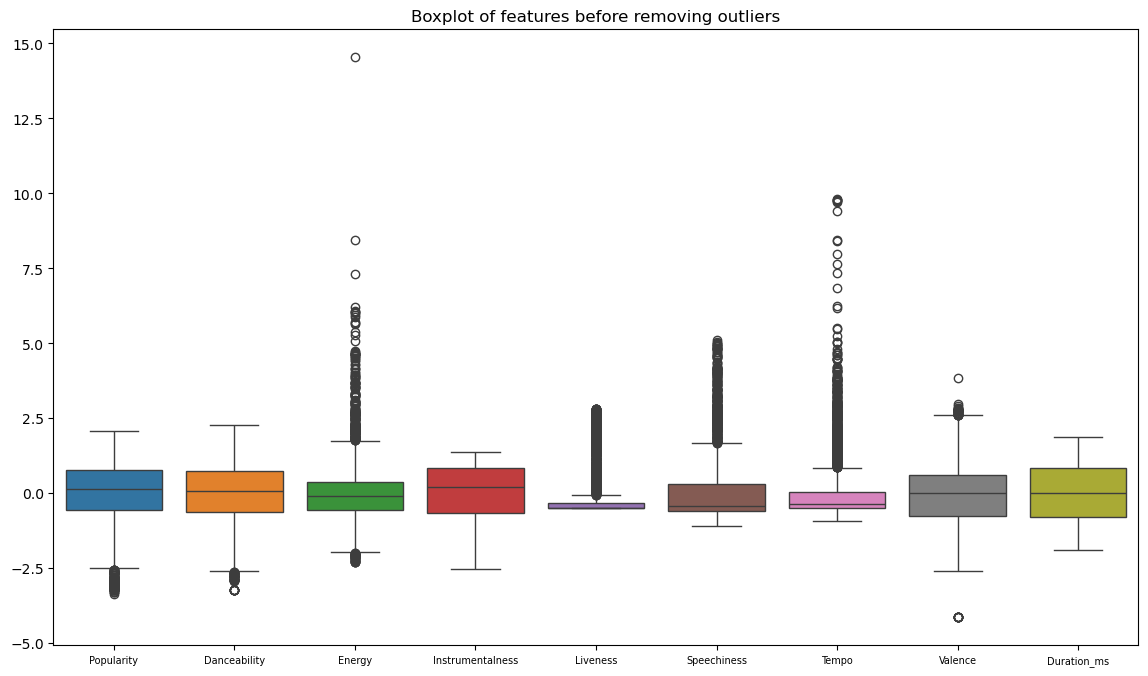

In [52]:
# checking for outliers after standardizing 
plt.figure(figsize=(14,8))
sns.boxplot(sd_df)
plt.xticks(fontsize=7)
plt.title('Boxplot of features before removing outliers')
plt.show()

#### Discarding outliers

In [301]:
# Converting the name column values to lower case
transformed_df['Name']= [x.lower() for x in transformed_df['Name']]

from scipy.stats import zscore

threshold=3

zscores= np.abs(transformed_df.iloc[:,5:].apply(zscore))
# Filter the DataFrame to exclude rows with any z-score above the threshold
filtered_df = transformed_df[(zscores < threshold).all(axis=1)]

filtered_df=filtered_df.reset_index()

filtered_df=filtered_df.drop(['index'],axis=1)

In [367]:
# View the filtered data
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              3374 non-null   object 
 1   Genre             3374 non-null   int32  
 2   Artist            3374 non-null   int32  
 3   Mode              3374 non-null   int64  
 4   Key               3374 non-null   int64  
 5   Popularity        3374 non-null   float64
 6   Danceability      3374 non-null   float64
 7   Energy            3374 non-null   float64
 8   Instrumentalness  3374 non-null   float64
 9   Liveness          3374 non-null   float64
 10  Speechiness       3374 non-null   float64
 11  Tempo             3374 non-null   float64
 12  Valence           3374 non-null   float64
 13  Duration_ms       3374 non-null   float64
 14  Cluster_id        3374 non-null   int32  
dtypes: float64(9), int32(3), int64(2), object(1)
memory usage: 356.0+ KB
None


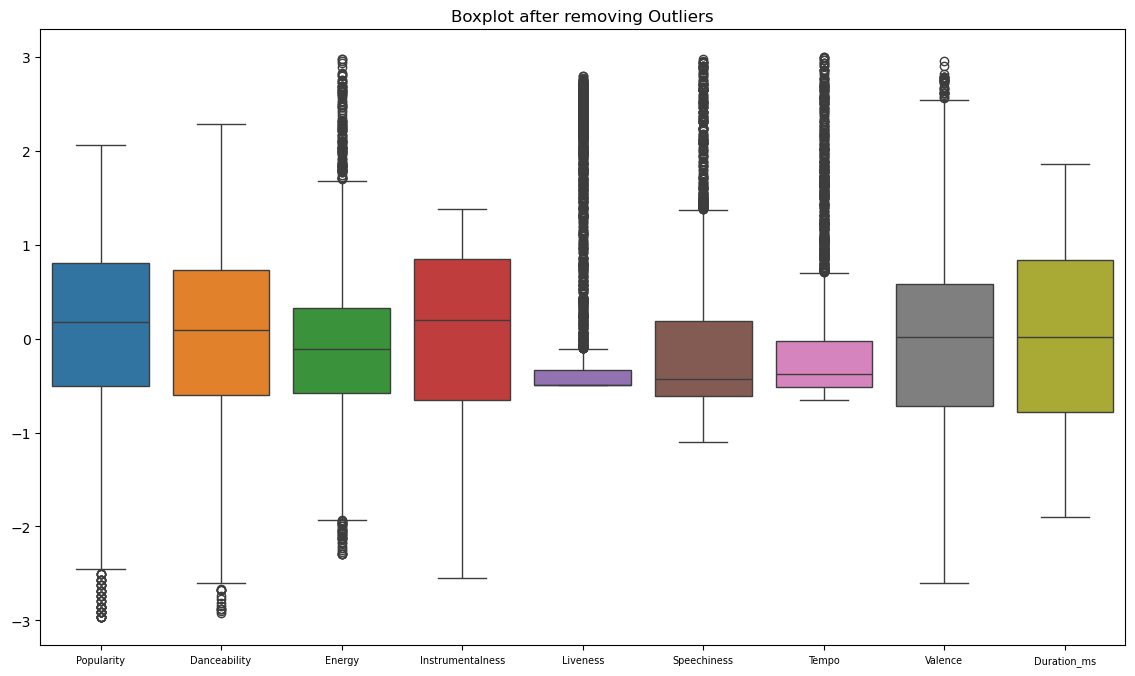

In [53]:
plt.figure(figsize=(14,8))
sns.boxplot(filtered_df.iloc[:,5:])
plt.xticks(fontsize=7)
plt.title('Boxplot after removing Outliers')
plt.show()

# Clustering

### Kmeans:

In [369]:
inertia=[]
silhouette=[]
k= list(range(2,20))
for i in k:
    kmeans=KMeans(n_clusters=i,random_state=42)
    kmeans.fit(filtered_df.iloc[:,1:])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(filtered_df.iloc[:,1:],kmeans.labels_))
    print(i,"Silhouette:",silhouette_score(filtered_df.iloc[:,1:],kmeans.labels_))

2 Silhouette: 0.6328147634016287
3 Silhouette: 0.5833582325960166
4 Silhouette: 0.5568857496581137
5 Silhouette: 0.5351196173047587
6 Silhouette: 0.5186719364051464
7 Silhouette: 0.4952603954400073
8 Silhouette: 0.4887387291925701
9 Silhouette: 0.47549915768782547
10 Silhouette: 0.46577684608960457
11 Silhouette: 0.4641953242180045
12 Silhouette: 0.4441341347900661
13 Silhouette: 0.42518725619066905
14 Silhouette: 0.4197042501357506
15 Silhouette: 0.4148360620392412
16 Silhouette: 0.40077899712501286
17 Silhouette: 0.3831362992567477
18 Silhouette: 0.3725460674084342
19 Silhouette: 0.37399177776105386


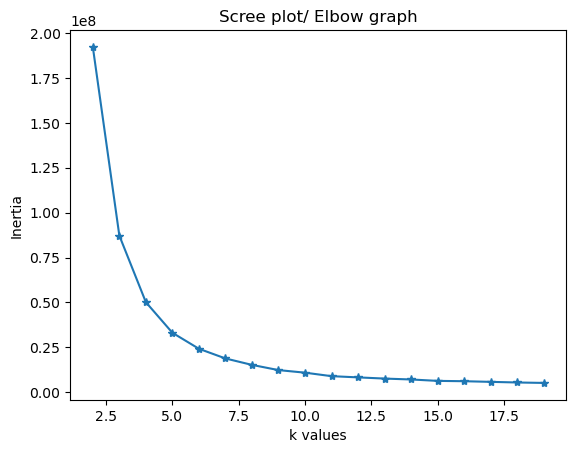

In [370]:
k= list(range(2,20))
plt.plot(k,inertia,marker='*')
plt.title('Scree plot/ Elbow graph') 
plt.xlabel('k values')
plt.ylabel('Inertia')
plt.show()

#### DBSCAN

In [56]:

# Parameters to search
# MinPts >= D+1
params = {'eps': list(np.arange(0.1, 0.9, 0.3)) + list(range(1, 20, 2)),
          'min_samples': [5,10,15,20,25]}

best_score = -1
best_params = {}

# Data for clustering
X = filtered_df.iloc[:, 1:]

# Manual grid search
for eps in params['eps']:
    for min_samples in params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore noise points (label = -1) for silhouette score
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (labels == -1).sum():  # Ensures that there are more than 1 clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.18755617734647553
Best Parameters: {'eps': 19, 'min_samples': 15}


### Applying PCA- Principle Component Analysis:

In [371]:
from sklearn.decomposition import PCA  

pca=PCA()
pca_components= pca.fit_transform(filtered_df.iloc[:,1:])
pca_components= pd.DataFrame(pca_components)

# preview of the PC's
pca_components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,744.452114,-45.240087,-5.259447,0.573563,1.253019,-1.673914,0.028657,0.266477,-0.264083,0.023205,0.091565,-0.560421,0.762087,0.113191
1,394.448472,-45.071858,-3.283641,-0.823646,0.769844,0.173466,0.993072,-0.055964,0.329442,0.362053,-0.412432,0.083606,-0.100527,-0.683216
2,-537.547884,-44.577638,-3.475915,1.877420,-0.418475,-0.683350,1.513834,0.724692,0.122122,-0.397175,0.737450,-0.068540,-0.483926,0.389027
3,316.447300,-45.045530,4.664681,-0.686931,1.328351,0.633730,-0.242329,1.430539,0.344272,0.139397,-0.863044,0.346023,0.382467,0.270772
4,-151.543643,-44.768133,-1.418236,4.195729,-1.043789,-0.084047,1.353316,0.878083,0.286923,-0.943563,0.329877,0.464901,-0.128470,0.270281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,-485.495635,61.369950,5.739397,1.358208,-0.437298,1.039732,-1.054909,-0.895627,-0.055291,2.241262,1.219199,0.075448,-0.779706,-0.077229
3370,-722.500664,61.487588,-3.372685,-2.315165,1.511587,0.257347,-1.231505,-0.329933,-0.826001,0.060641,-1.051453,0.053793,-0.367782,0.268304
3371,677.498819,60.769508,-4.071564,-3.714676,-0.430560,0.868066,-0.631575,-0.821984,0.908492,1.496474,0.948630,-0.494568,0.020196,0.536230
3372,-722.500673,61.484791,-3.348465,-2.286300,1.123614,0.154419,-1.666260,-0.703545,1.087658,-0.517395,-0.529856,-0.580641,-0.485787,0.321088


In [58]:
# PC's shouldn't be correletaed to each other and we can see below that they aren't correlated.
np.round(pca_components.corr(),4)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
1,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
2,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
3,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
4,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
5,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
6,-0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
7,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,0.0
8,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0
9,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0


In [372]:
variance= pd.DataFrame(pca_components.var(), columns=['Variances'])
variance['Percentages']= pd.Series(pca.explained_variance_ratio_ * 100)
variance['cumsum']= pd.Series(np.cumsum(variance['Percentages']))
variance

,Variances,Percentages,cumsum
0,237803.886793,99.610769,99.610769
1,901.861221,0.377770,99.988539
2,12.581790,0.005270,99.993809
3,7.166392,0.003002,99.996811
4,1.965721,0.000823,99.997635
5,1.237906,0.000519,99.998153
6,0.982849,0.000412,99.998565
7,0.745396,0.000312,99.998877
8,0.623002,0.000261,99.999138
9,0.563802,0.000236,99.999374


#### From above we will be considering first three pc's as first three clusters include 99.998 percentage of data.

### Clustering- Kmeans- PCA

In [374]:
print("Checking for the best k value with best silhouette score:")
inertia=[]
silhouette=[]
k= list(range(2,20))
for i in k:
    kmeans=KMeans(n_clusters=i,random_state=42)
    kmeans.fit(pca_components.iloc[:,0:3])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_components.iloc[:,0:3],kmeans.labels_))
    print(i,"Silhouette:",silhouette_score(pca_components.iloc[:,0:3],kmeans.labels_))

Checking for the best k value with best silhouette score:
2 Silhouette: 0.6329192077758714
3 Silhouette: 0.5835781952786939
4 Silhouette: 0.557829424287432
5 Silhouette: 0.5352823948201999
6 Silhouette: 0.5193776882920702
7 Silhouette: 0.4958486144522442
8 Silhouette: 0.48451720559084344
9 Silhouette: 0.4756960325896779
10 Silhouette: 0.47077469561383284
11 Silhouette: 0.45049071334413954
12 Silhouette: 0.44640583322999516
13 Silhouette: 0.43940560223730013
14 Silhouette: 0.4273302335274872
15 Silhouette: 0.40622109504072734
16 Silhouette: 0.39728362323886435
17 Silhouette: 0.38991682935916766
18 Silhouette: 0.38612466449981214
19 Silhouette: 0.3809104685515805


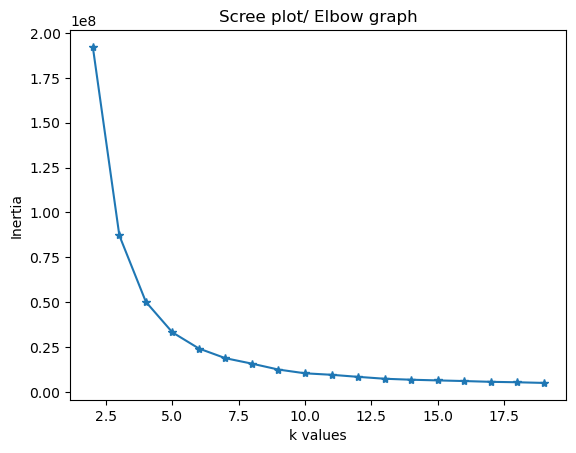

In [376]:
k= list(range(2,20))
plt.plot(k,inertia,marker='*')
plt.title('Scree plot/ Elbow graph') 
plt.xlabel('k values')
plt.ylabel('Inertia')
plt.show()

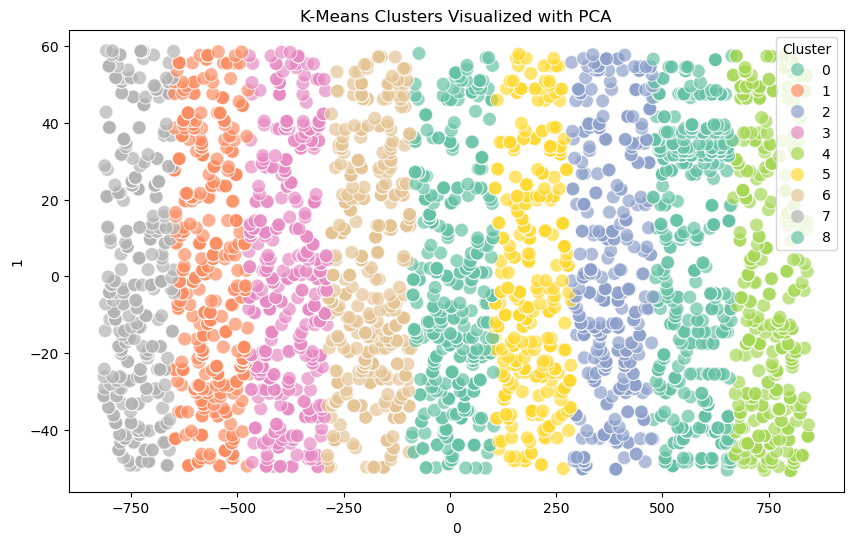

In [61]:
kmeans=KMeans(n_clusters=9,random_state=42)
labels=kmeans.fit_predict(pca_components.iloc[:,0:3])

# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(pca_components.iloc[:,0:3])

# Add the cluster labels
df_pca['Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], hue='Cluster', palette='Set2', s=100, alpha=0.7)
plt.title('K-Means Clusters Visualized with PCA')
plt.show()

#### DBSCAN- PCA

In [62]:
# Parameters to search
params = {'eps': list(np.arange(0.1,0.9,0.2)) + list(range(1,20,2)),
          'min_samples': [5, 10, 12, 15, 20]}

best_score = -1
best_params = {}

# Data for clustering
X = pca_components.iloc[:,0:4]

# Manual grid search
for eps in params['eps']:
    for min_samples in params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore noise points (label = -1) for silhouette score
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (labels == -1).sum():  # Ensures that there are more than 1 clusters
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                

print(f"Best Silhouette Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Silhouette Score: 0.17119663445385624
Best Parameters: {'eps': 19, 'min_samples': 20}


In [201]:
# Fit DBSCAN with best parameters
dbscan_best = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_best.fit(X)
labels=dbscan_best.labels_
print('Silhouette Score:',silhouette_score(X, labels))
print("No. of clusters:",len(set(labels)))

Silhouette Score: 0.2335254770419128
No. of clusters: 218


# Final cluster: Kmeans with k= 10

In [377]:
kmeans=KMeans(n_clusters=10,random_state=42)
Labels=kmeans.fit_predict(filtered_df.iloc[:,1:])

# Silhouette score
print("Silhouette score:",silhouette_score(filtered_df.iloc[:,1:], Labels))

# Add the cluster labels to the original dataset
filtered_df.loc[:, 'Cluster_id'] = Labels

Silhouette score: 0.46577684608960457


In [309]:
filtered_df.loc[:, 'Cluster_id'].value_counts()

Cluster_id
5    451
1    414
3    401
0    337
8    331
7    310
2    306
4    297
9    267
6    260
Name: count, dtype: int64

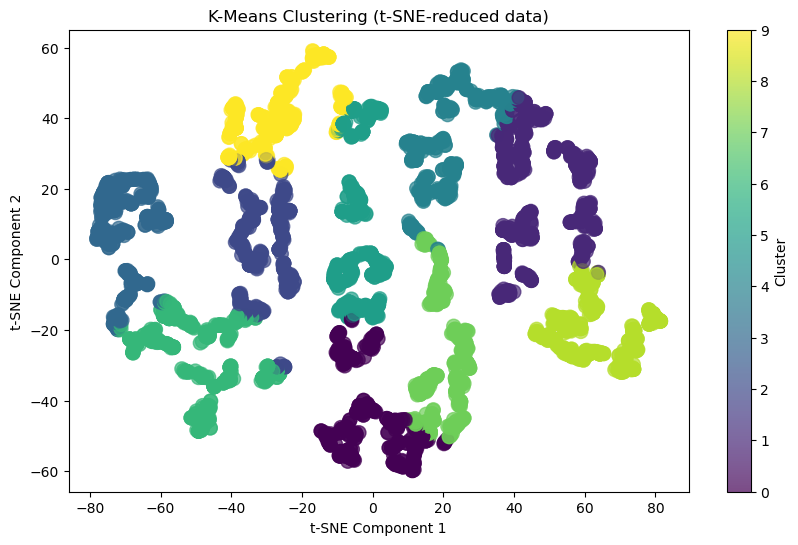

In [234]:
# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(filtered_df.iloc[:, 1:]) 


# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = Labels

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering (t-SNE-reduced data)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [205]:
final_df.to_excel('final_tracks.xlsx',index=False)

# Model Building 1

In [379]:
# Function to recommend songs from the same cluster
def recommend_songs(song_name, data, num_recommendations):
    song_name=song_name.lower()
    if song_name in data['Name'].values:
        cluster = data.loc[data['Name'] == song_name, 'Cluster_id'].values[0]
    recommendations = data[(data['Cluster_id'] == cluster) & (data['Name'] != song_name)].sample(num_recommendations)
    return recommendations[['Name']]


recommendations = recommend_songs('hold on',filtered_df,10)
recommendations

,Name
1159,all goes wrong
2231,now you can sleep
1166,tough talk (feat. kwengface)
2528,obey (with yungblud)
1237,satisfied
2260,gyal you a party animal - sped up
1679,heartwork
1785,when she loved me - john connearn version
1326,u are my high (with future)
1182,hollow


<h1> Data extraction using TfidfVectorizer </h1>

In [177]:
transformed_df.columns

Index(['Name', 'Genre', 'Artist', 'Mode', 'Key', 'Popularity', 'Danceability',
       'Energy', 'Instrumentalness', 'Liveness', 'Speechiness', 'Tempo',
       'Valence', 'Duration_ms'],
      dtype='object')

In [207]:
# Concatenating the transformed columns to the categorical columns
transformed_df=pd.concat([df_cleaned[['Name','Genre','Artist','Mode','Key']],sd_df],axis=1)

# Converting the name column values to lower case
transformed_df['Name']= [x.lower() for x in transformed_df['Name']]

In [208]:
# removing outliers
from scipy.stats import zscore

threshold=3

zscores= np.abs(transformed_df.iloc[:,5:].apply(zscore))
# Filter the DataFrame to exclude rows with any z-score above the threshold
songs_df = transformed_df[(zscores < threshold).all(axis=1)]

songs_df=songs_df.reset_index()

songs_df=songs_df.drop(['index'],axis=1)

In [209]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374 entries, 0 to 3373
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              3374 non-null   object 
 1   Genre             3374 non-null   object 
 2   Artist            3374 non-null   object 
 3   Mode              3374 non-null   int64  
 4   Key               3374 non-null   int64  
 5   Popularity        3374 non-null   float64
 6   Danceability      3374 non-null   float64
 7   Energy            3374 non-null   float64
 8   Instrumentalness  3374 non-null   float64
 9   Liveness          3374 non-null   float64
 10  Speechiness       3374 non-null   float64
 11  Tempo             3374 non-null   float64
 12  Valence           3374 non-null   float64
 13  Duration_ms       3374 non-null   float64
dtypes: float64(9), int64(2), object(3)
memory usage: 369.2+ KB


In [334]:

# Merging all the text columns
songs_df['Merged_col'] = (songs_df['Name'] + ' ' + songs_df['Artist'] + ' ' + songs_df['Genre'])
#songs_df['Merged_col'] = ( songs_df['Artist'] + ' ' + songs_df['Genre'])


# Removing whitespace or filtering out any empty string
songs_df = songs_df[songs_df['Merged_col'].str.strip() != '']
Merged_data = songs_df['Merged_col']

# Converting to lower case
Merged_data = Merged_data.apply(lambda x: x.lower())

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)]

    stop_words= stopwords.words('english')

    no_stopwords_token= [x for x in tokens if x not in stop_words]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(t) for t in no_stopwords_token]
    
    return stems

In [359]:
Merged_data

0              blister in the sun violent femmes acoustic
1                       love song sara bareilles acoustic
2                       hold on chord overstreet acoustic
3          you are the best thing ray lamontagne acoustic
4                     i won't give up jason mraz acoustic
                              ...                        
3369               the launch - radio edit dj jean trance
3370    in the dark (feat. aldae) armin van buuren trance
3371                         split (only u) tiësto trance
3372    in the dark (feat. aldae) - extended mix armin...
3373    viva l'opera (asot 1186) [tune of the week] ar...
Name: Merged_col, Length: 3374, dtype: object

In [335]:
songs_token = []
for i in Merged_data:
    tk = tokenize_and_stem(i)
    songs_token.append(tk)
    print(tk)

['blister', 'sun', 'violent', 'femm', 'acoust']
['love', 'song', 'sara', 'bareill', 'acoust']
['hold', 'chord', 'overstreet', 'acoust']
['best', 'thing', 'ray', 'lamontagn', 'acoust']
['wo', "n't", 'give', 'jason', 'mraz', 'acoust']
['born', 'love', 'ray', 'lamontagn', 'acoust']
['find', 'peopl', 'drew', 'holcomb', '&', 'neighbor', 'acoust']
['nake', 'came', 'iron', '&', 'wine', 'acoust']
['come', 'get', 'higher', 'matt', 'nathanson', 'acoust']
['flightless', 'bird', ',', 'american', 'mouth', 'iron', '&', 'wine', 'acoust']
['call', 'dream', 'iron', '&', 'wine', 'acoust']
['brand', 'new', 'ben', 'rector', 'acoust']
['asleep', 'among', 'endiv', 'ichiko', 'aoba', 'acoust']
['breath', '(', '2', ')', 'anna', 'nalick', 'acoust']
['ingrid', 'michaelson', 'acoust']
['save', 'later', 'eddi', 'vedder', 'acoust']
['stori', 'brandi', 'carlil', 'acoust']
['love', 'kurt', 'cobain', 'acoust']
['window', 'roll', 'amo', 'lee', 'acoust']
['upon', 'dream', 'disney', 'peac', 'guitar', 'acoust']
['babi', '

In [336]:
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=5000, min_df=0.0, 
                                   use_idf=True, ngram_range=(1, 3), tokenizer=tokenize_and_stem,token_pattern=None)

# Fit and transform the Merged_data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(Merged_data)

# The tfidf_matrix is now ready for use

In [338]:
from scipy.sparse import hstack

combined_features = hstack([tfidf_matrix, songs_df[['Popularity', 'Danceability', 'Energy',
       'Instrumentalness', 'Liveness', 'Speechiness', 'Tempo', 'Valence',
       'Mode', 'Key', 'Duration_ms']]])


In [339]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(combined_features)
cosine_sim

array([[ 1.        ,  0.1111602 ,  0.18598949, ..., -0.08506803,
         0.21730351, -0.1304644 ],
       [ 0.1111602 ,  1.        ,  0.54684942, ...,  0.19023554,
         0.47172478,  0.71488873],
       [ 0.18598949,  0.54684942,  1.        , ...,  0.22302836,
         0.2279464 ,  0.62789138],
       ...,
       [-0.08506803,  0.19023554,  0.22302836, ...,  1.        ,
         0.36071973,  0.44309632],
       [ 0.21730351,  0.47172478,  0.2279464 , ...,  0.36071973,
         1.        ,  0.62780195],
       [-0.1304644 ,  0.71488873,  0.62789138, ...,  0.44309632,
         0.62780195,  1.        ]])

In [349]:
sim_df=pd.DataFrame(cosine_sim,columns=songs_df['Name'], index=songs_df['Name'])
# filling the digonal values to sero
np.fill_diagonal(sim_df.values, 0)
sim_df

Name,blister in the sun,love song,hold on,you are the best thing,i won't give up,i was born to love you,find your people,naked as we came,come on get higher,"flightless bird, american mouth",...,tell it to my heart,sorry you're not a winner,take me away (into the night) - vocal radio mix,lose this feeling - dimension remix,greece 2000,the launch - radio edit,in the dark (feat. aldae),split (only u),in the dark (feat. aldae) - extended mix,viva l'opera (asot 1186) [tune of the week]
Name,,,,,,,,,,,,,,,,,,,,,
blister in the sun,0.000000,0.111160,0.185989,0.080335,-0.026316,0.066194,0.193610,0.119893,0.157297,-0.129379,...,-0.031313,0.006851,-0.132371,-0.359641,0.070554,-0.090308,0.277698,-0.085068,0.217304,-0.130464
love song,0.111160,0.000000,0.546849,0.795926,0.632963,0.728920,0.732947,0.579191,0.778220,0.582478,...,0.732760,0.671239,0.695692,-0.007426,0.218091,0.687782,0.537280,0.190236,0.471725,0.714889
hold on,0.185989,0.546849,0.000000,0.605389,0.834702,0.746049,0.692848,0.659396,0.679988,0.773190,...,0.586400,0.585409,0.639933,-0.181810,-0.040289,0.556330,0.190877,0.223028,0.227946,0.627891
you are the best thing,0.080335,0.795926,0.605389,0.000000,0.811416,0.898165,0.872990,0.837535,0.947248,0.745543,...,0.932497,0.890392,0.843623,0.085935,0.348130,0.909084,0.673987,0.332081,0.636065,0.922457
i won't give up,-0.026316,0.632963,0.834702,0.811416,0.000000,0.895224,0.810479,0.832594,0.836027,0.907855,...,0.779594,0.780658,0.776797,-0.100037,0.048191,0.755646,0.329503,0.249789,0.370252,0.837676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
the launch - radio edit,-0.090308,0.687782,0.556330,0.909084,0.755646,0.884631,0.841525,0.673931,0.909387,0.655669,...,0.933096,0.898420,0.853578,0.158933,0.463982,0.000000,0.550154,0.525747,0.543833,0.934490
in the dark (feat. aldae),0.277698,0.537280,0.190877,0.673987,0.329503,0.496534,0.639589,0.475772,0.621919,0.267610,...,0.690499,0.515317,0.528695,0.146613,0.268488,0.550154,0.000000,0.157191,0.772503,0.602631
split (only u),-0.085068,0.190236,0.223028,0.332081,0.249789,0.289195,0.235043,0.130758,0.335459,0.247435,...,0.403938,0.460522,0.345667,0.447624,0.638153,0.525747,0.157191,0.000000,0.360720,0.443096


# Model building 2

In [357]:
def recommend_songs(song_name, sim_matrix, data,top_n):
    song_name=song_name.lower()
    sim_values=sim_matrix[song_name].values.tolist()
    sim_values=enumerate(sim_values)
    sim_values=sorted(sim_values, key=lambda x: x[1], reverse=True)
    top_n_indices=[x[0] for x in sim_values[0:top_n+1]]
    return data.iloc[top_n_indices,0:3]

In [378]:
recommend_songs('hold on', sim_df, songs_df,10)

,Name,Genre,Artist
3116,photograph,singer-songwriter,Ed Sheeran
2711,your song,piano,Elton John
3032,can we kiss forever?,sad,Kina
445,easy on me,british,Adele
821,heading south,country,Zach Bryan
345,"up where we belong - from ""an officer and a ge...",blues,Joe Cocker
723,lost in the fire (feat. the weeknd),club,Gesaffelstein
4,i won't give up,acoustic,Jason Mraz
54,someone you loved - acoustic,acoustic,Plamina
2870,back to the old house - 2011 remaster,punk,The Smiths
